# Imports

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
%matplotlib inline

# Data
After reading in data, we also need to separate the `location` variable into its corresponding latitude and longitude coordinates.

In [10]:
# Read in data
data = pd.read_json('../data_json/traffic_data.zip', orient='index', convert_axes=False)
# orient --> indicates expected json string format, we're oriented on the indicies
# convert_axis --> to stop from labeling index (accident id) as datetime

data.head()

,Area ID,Premise Description,Location,month,day,year,hour,day_category
100100007,1,STREET,"(34.0395, -118.2656)",11,8,2010,22,night
100100767,1,STREET,"(34.0695, -118.2324)",3,31,2010,4,night
100100831,1,STREET,"(34.0424, -118.2718)",4,18,2010,1,night
100101004,1,STREET,"(34.0344, -118.2714)",6,5,2010,20,night
100101322,1,STREET,"(34.0637, -118.2361)",8,7,2010,16,evening


In [11]:
def get_latitude(loc):
    lat, _, _ = loc.partition(',')
    lat = lat.replace('(', '')

    return float(lat)

def get_longitude(loc):
    _, _, long = loc.partition(',')
    long = long.replace(')', '')

    return float(long)

In [12]:
data['lat'] = data.Location.apply(get_latitude)
data['long'] = data.Location.apply(get_longitude)
data.drop(columns='Location', inplace=True)
data[['lat', 'long']].head()

,lat,long
100100007,34.0395,-118.2656
100100767,34.0695,-118.2324
100100831,34.0424,-118.2718
100101004,34.0344,-118.2714
100101322,34.0637,-118.2361


In [16]:
# Filter out coordinates that fall outside the rough range of Los Angeles
data = data[(data['lat'] <= 36) & (data['long'] <= -110)] 

# 1st Clustering Approach - Kmodes
Because the majority of our data is categorical, we have chosen to explore the kmodes clustering implementation which uses a different dissimlarity measure and utilizes the most frequent category (mode) instead of the mean.

## Binning Location coordinates
Since our approach is kmodes we need to convert all of our variables into categorical. Our only true numeric variable is latitude and longitude, so we are interested in binning these locations to perform kmodes.

<AxesSubplot:xlabel='lat', ylabel='Count'>

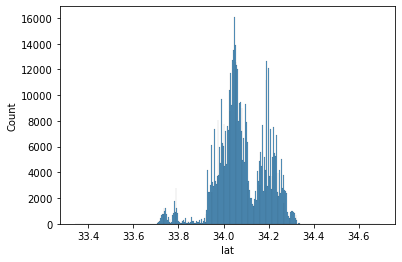

In [17]:
sns.histplot(data=data, x='lat', bins=10)

# 2nd Clustering Approach --> K-Prototypes (mix between K-means and K-modes)

In [18]:
data.head()

,Area ID,Premise Description,month,day,year,hour,day_category,lat,long
100100007,1,STREET,11,8,2010,22,night,34.0395,-118.2656
100100767,1,STREET,3,31,2010,4,night,34.0695,-118.2324
100100831,1,STREET,4,18,2010,1,night,34.0424,-118.2718
100101004,1,STREET,6,5,2010,20,night,34.0344,-118.2714
100101322,1,STREET,8,7,2010,16,evening,34.0637,-118.2361


In [24]:
# Was having issues running --> had to kill kernel after 38 minutes of runtime
kproto = KPrototypes(n_clusters=3, init='Cao')

clusters = kproto.fit_predict(data, categorical=list(range(0, 7)))
labels = pd.DataFrame(clusters)
labeled_data = pd.concat((data, labels), axis=1)
labeled_data = labeled_data.rename({0: 'labels'}, axis=1)

KeyboardInterrupt: 

In [ ]:
labeled_data

# 3rd Clustering Approach --> Kmeans with One Hot Encoding

In [25]:
cat_cols = ['Area ID', 'Premise Description', 'month', 'day', 'year', 'hour', 'day_category']
data_enc = pd.get_dummies(data, columns=cat_cols)
data_enc.head()

,lat,long,Area ID_1,Area ID_2,Area ID_3,Area ID_4,Area ID_5,Area ID_6,Area ID_7,Area ID_8,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_category_afternoon,day_category_evening,day_category_morning,day_category_night
100100007,34.0395,-118.2656,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
100100767,34.0695,-118.2324,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
100100831,34.0424,-118.2718,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
100101004,34.0344,-118.2714,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
100101322,34.0637,-118.2361,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [33]:
kmeans = KMeans(3)
clusters = kmeans.fit_predict(data_enc)
labels = pd.DataFrame(clusters)
data_labeled = data.copy()
data_labeled['labels'] = labels.values
# data_labeled = pd.concat((data, labels), axis=1)
# data_labeled = data_labeled.rename({0: 'label'}, axis=1)

data_labeled

,Area ID,Premise Description,month,day,year,hour,day_category,lat,long,labels
100100007,1,STREET,11,8,2010,22,night,34.0395,-118.2656,1
100100767,1,STREET,3,31,2010,4,night,34.0695,-118.2324,1
100100831,1,STREET,4,18,2010,1,night,34.0424,-118.2718,1
100101004,1,STREET,6,5,2010,20,night,34.0344,-118.2714,1
100101322,1,STREET,8,7,2010,16,evening,34.0637,-118.2361,2
...,...,...,...,...,...,...,...,...,...,...
222104843,21,STREET,1,26,2022,19,night,34.1857,-118.5710,1
222104874,21,STREET,1,24,2022,15,afternoon,34.1938,-118.6059,0
222104886,21,STREET,1,24,2022,17,evening,34.1740,-118.5888,2
222104962,21,STREET,1,28,2022,19,night,34.1624,-118.6285,1


<AxesSubplot:xlabel='long', ylabel='lat'>

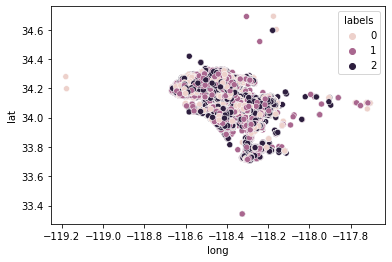

In [36]:
sns.scatterplot(data=data_labeled, x='long', y='lat', hue='labels')

In [38]:
l0 = data_labeled[data_labeled.labels == 0]
l1 = data_labeled[data_labeled.labels == 1]
l2 = data_labeled[data_labeled.labels == 2]

In [40]:
l0

,Area ID,Premise Description,month,day,year,hour,day_category,lat,long,labels
100104017,1,STREET,1,1,2010,12,afternoon,34.0453,-118.2651,0
100104019,1,STREET,1,1,2010,14,afternoon,34.0503,-118.2504,0
100104026,1,STREET,1,1,2010,15,afternoon,34.0371,-118.2551,0
100104126,1,STREET,1,3,2010,14,afternoon,34.0531,-118.2478,0
100104222,1,STREET,1,5,2010,13,afternoon,34.0396,-118.2558,0
...,...,...,...,...,...,...,...,...,...,...
222104641,21,STREET,1,20,2022,13,afternoon,34.2194,-118.6235,0
222104668,21,STREET,1,21,2022,12,afternoon,34.1710,-118.5709,0
222104792,21,STREET,1,25,2022,15,afternoon,34.1658,-118.6008,0
222104874,21,STREET,1,24,2022,15,afternoon,34.1938,-118.6059,0


In [41]:
l0.day_category.unique()

array(['afternoon'], dtype=object)

In [53]:
def examine_labels(data_red, col):
    sns.histplot(data_red, x=col)
    plt.show()

Cluster: 0
----------------
Column: Area ID
------------------------


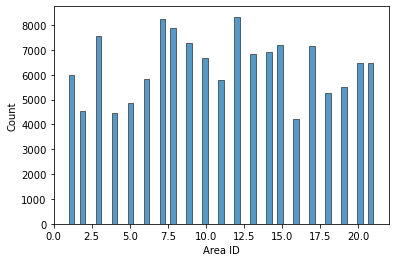

Column: Premise Description
------------------------
STREET                                            125884
PARKING LOT                                         5526
SIDEWALK                                             637
ALLEY                                                236
                                                     234
                                                   ...  
SHOPPING MALL (COMMON AREA)                            1
MTA BUS                                                1
TRAM/STREETCAR(BOXLIKE WAG ON RAILS)*                  1
LIBRARY                                                1
TRAIN, OTHER THAN MTA (ALSO QUERY 809/810/811)         1
Name: Premise Description, Length: 74, dtype: int64
Column: month
------------------------


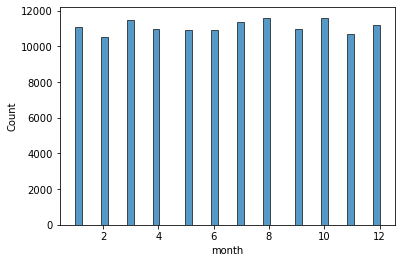

Column: day
------------------------


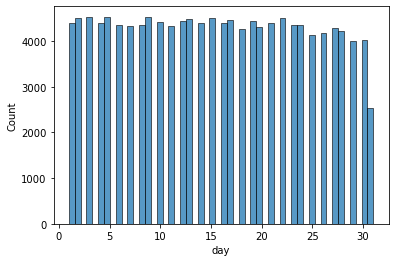

Column: year
------------------------


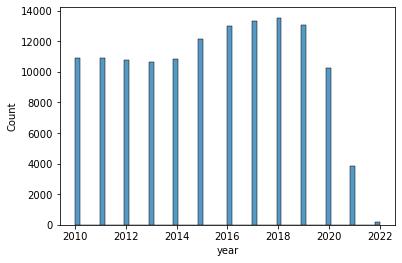

Column: hour
------------------------


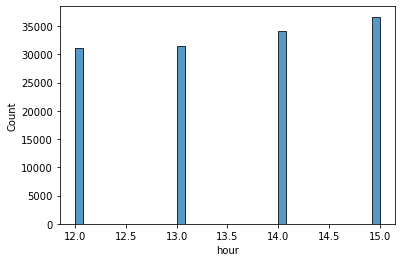

Column: day_category
------------------------


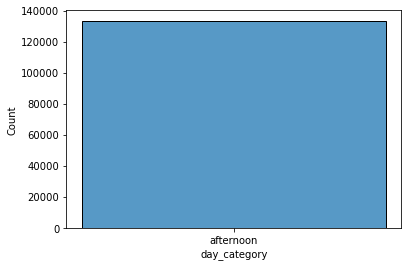

Cluster: 1
----------------
Column: Area ID
------------------------


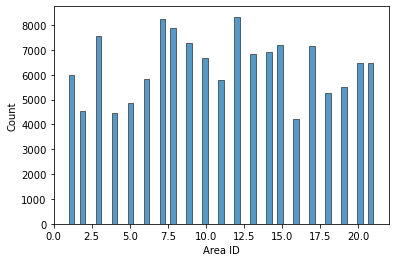

Column: Premise Description
------------------------
STREET                         178676
PARKING LOT                      4840
SIDEWALK                         1149
DRIVEWAY                          364
ALLEY                             348
                                ...  
TV/RADIO/APPLIANCE                  1
NAIL SALON                          1
MANUFACTURING COMPANY               1
MOTEL                               1
MTA PROPERTY OR PARKING LOT         1
Name: Premise Description, Length: 81, dtype: int64
Column: month
------------------------


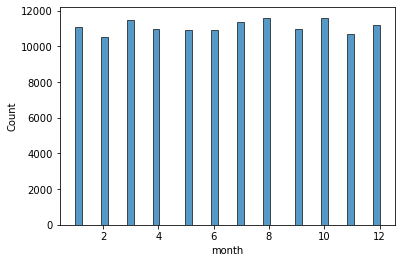

Column: day
------------------------


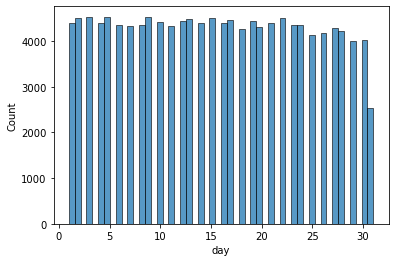

Column: year
------------------------


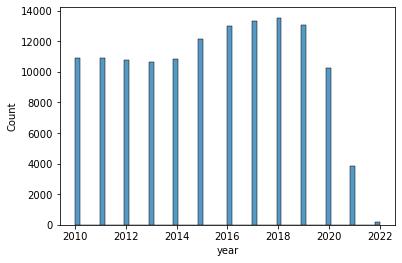

Column: hour
------------------------


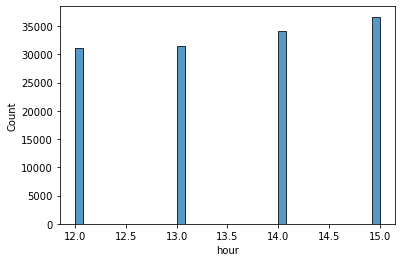

Column: day_category
------------------------


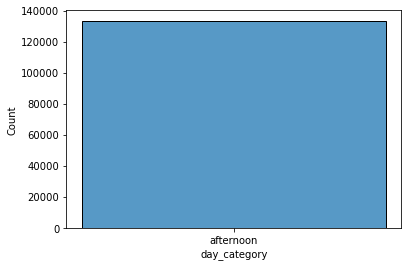

Cluster: 2
----------------
Column: Area ID
------------------------


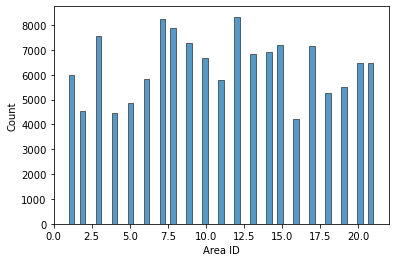

Column: Premise Description
------------------------
STREET                                     238698
PARKING LOT                                  7654
SIDEWALK                                     1270
DRIVEWAY                                      435
ALLEY                                         431
                                            ...  
ENTERTAINMENT/COMEDY CLUB (OTHER)               1
BUS, SCHOOL, CHURCH                             1
MAIL BOX                                        1
AUTOMATED TELLER MACHINE (ATM)                  1
MEDICAL MARIJUANA FACILITIES/BUSINESSES         1
Name: Premise Description, Length: 82, dtype: int64
Column: month
------------------------


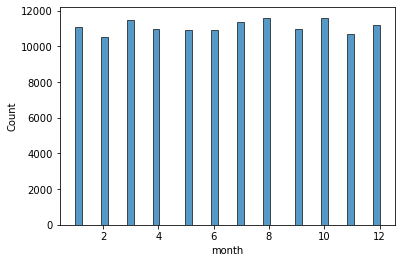

Column: day
------------------------


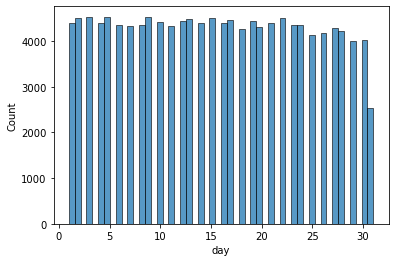

Column: year
------------------------


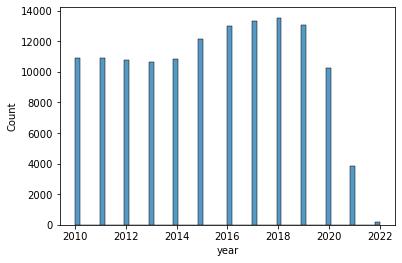

Column: hour
------------------------


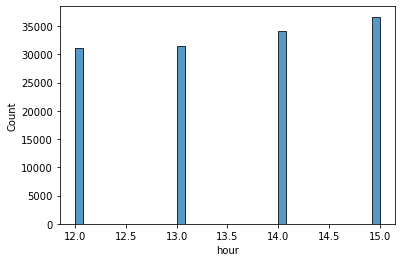

Column: day_category
------------------------


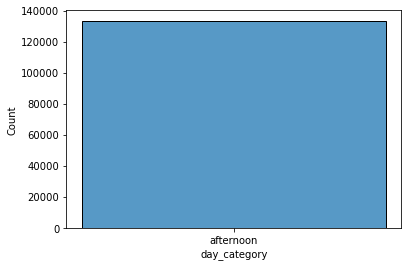

In [56]:
clusters = [l0, l1, l2]
for i, cluster in enumerate(clusters):
    print(f'Cluster: {i}')
    print('----------------')
    for col in cat_cols:
        print(f'Column: {col}')
        print('------------------------')
        if col == 'Premise Description':
            print(cluster[col].value_counts())
        
        else:
            examine_labels(l0, col)
